In [1]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we 
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    colab_compat = True # deactivate preview
except:
    colab_compat = False
resolution = [480,320] # increase for higher quality of renderings

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
gpu_num = 0
if gpus:
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e) 
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility

# Import Sionna
import sys
print(os.getcwd())
sys.path.append('../')
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    print('no sionna')
    # os.system("pip install sionna")
    # import sionna
  
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
    
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, RadioMaterial, Camera
from sionna.rt.utils import r_hat
from sionna.constants import PI, SPEED_OF_LIGHT
from sionna.utils import expand_to_rank

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/afs/cs.pitt.edu/usr0/zha21/Documents/GitHub/sionna-new/sionna/examples


In [2]:
scene = load_scene(sionna.rt.scene.simple_thickwall) 
# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")


# Create transmitter
tx = Transmitter(name="tx",
                 position=[-2, 0, 2])

# Add transmitter instance to scene
scene.add(tx)

# Create a receiver
rx1 = Receiver(name="rx1",
              position=[1, 1, 1.5],
              orientation=[0,0,0])
rx2 = Receiver(name="rx2",
              position=[1, -1, 1.5],
              orientation=[0,0,0])
# Add receiver instance to scene
scene.add(rx1)
scene.add(rx2)
tx.look_at(rx1) # Transmitter points towards receiver
scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [4]:
traced_paths = scene.trace_paths(los=False, reflection=True, scattering=False, diffraction=False, refraction=True,
                                max_depth=4,
                                num_samples=1e4)
paths = scene.compute_fields(*traced_paths, scat_random_phases=False)
scene.preview(paths, show_devices=True, show_paths=True) # Use the mouse to focus on the visualized paths

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, matrixWorldNeedsUpda…

time tf.Tensor(
[ 2.1956957e+01  1.5734188e+01 -1.0000000e+09  1.0679262e+01
 -1.0000000e+09 -1.0000000e+09 -1.0000000e+09 -1.0000000e+09
 -1.0000000e+09 -1.0000000e+09 -1.0000000e+09 -1.0000000e+09
 -1.0000000e+09 -1.0000000e+09 -1.0000000e+09 -1.0000000e+09
 -1.0000000e+09 -1.0000000e+09 -1.0000000e+09 -1.0000000e+09
 -1.0000000e+09 -1.0000000e+09  2.4582993e+01 -1.0000000e+09
 -1.0000000e+09 -1.0000000e+09 -1.0000000e+09 -1.0000000e+09
 -1.0000000e+09 -1.0000000e+09 -1.0000000e+09 -1.0000000e+09
 -1.0000000e+09  2.1956957e+01  1.8670565e+01 -1.0000000e+09
 -1.0000000e+09 -1.0000000e+09 -1.0000000e+09 -1.0000000e+09
 -1.0000000e+09 -1.0000000e+09 -1.0000000e+09 -1.0000000e+09
 -1.0000000e+09 -1.0000000e+09 -1.0000000e+09  1.0679261e+01
            inf            inf            inf  3.2798565e+01
 -1.0000000e+09 -1.0000000e+09], shape=(54,), dtype=float32)


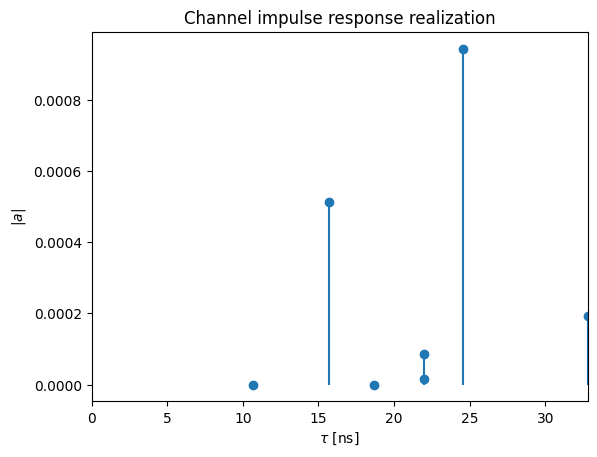

In [11]:
paths.normalize_delays = False
a, tau = paths.cir()
t = tau[0,0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,0,:,0]
a_max = np.max(a_abs)
print('time', t)
# Add dummy entry at start/end for nicer figure
t = np.concatenate([(0.,), t, (np.max(t)*1.1,)])
a_abs = np.concatenate([(np.nan,), a_abs, (np.nan,)])

# And plot the CIR
plt.figure()
plt.title("Channel impulse response realization")

plt.stem(t, a_abs)
plt.xlim([0, np.max(t[~np.isinf(t)])])
# plt.ylim([-2e-6, a_max*1.1])
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$");